# Przewidywanie hałasu płatu lotniczego na podstawie obserwacji w tunelu aerodynamicznym (Airfoil Self-Noise)

### 1.Import bibliotek

Wszystkie potrzebne biblioteki do wykonania zadania zostały zaimportowane na samym początku.

In [408]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### 2.Załadowanie danych - plik airfoil_self_noise.dat

W pierwszym kroku musimy załadować nasze dane. Skorzystaliśmy z odpowiedniego pliku umieszczonego na stronie https://archive.ics.uci.edu/. Ponieważ plik który pobraliśmy nie posiadał wiersza z nagłówkami konieczne byłoby dodanie go - w metodzie pd.read_csv metoda names = features_names(wcześniej zdefiniowana tablica nagłówków)

In [409]:
feature_names = ['Frequency','Angle','Chord Length','velocity','displacement thickness','sound_pressure']
airfoil_self_noise = pd.read_csv("airfoil_self_noise.dat",header=None,sep='\t',names=feature_names)

### 3.Przedstawienie Danych

Poniżej przedstawiamy nasze dane które będziemy brali pod uwage przy tworzeniu naszego modelu. W pierwszej kolejności przedstawiliśmy dane w formie tekstu - funkcja describe() przedstawia ilość(count) wartości, średnią(mean) wartość, standardowe odchylenie(std) wartości, wartość minimalną,25%,50%,75%, oraz wartość maksymalną. Kolejna komenda przedstawia pierwsze oraz ostatnie 5 kolumn. Następnie dane zostały przedstawione w formie wizualnej za pomocą wykresów.

In [410]:
airfoil_self_noise.describe()

,Frequency,Angle,Chord Length,velocity,displacement thickness,sound_pressure
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [411]:
airfoil_self_noise

,Frequency,Angle,Chord Length,velocity,displacement thickness,sound_pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


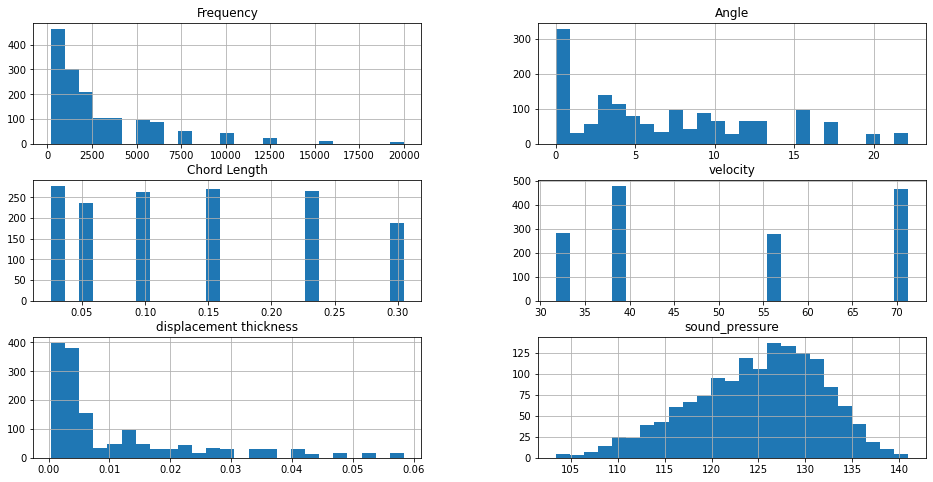

In [412]:
airfoil_self_noise.hist(bins=25,figsize=(16,8));


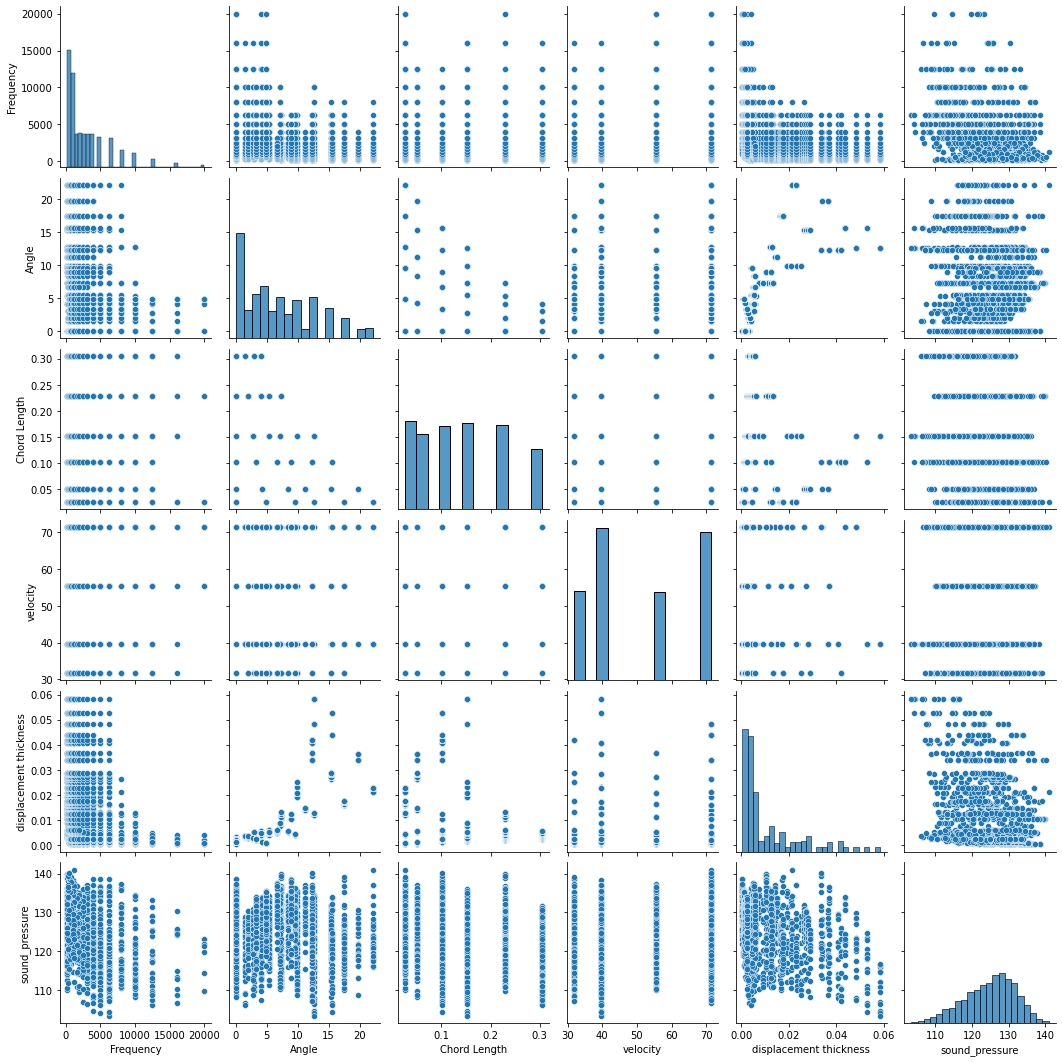

In [413]:
sns.pairplot(airfoil_self_noise)


### 4.Podział danych na cechy oraz wynik docelowy(target)

Poniżej zbiór danych został podzielony na dwa podzbiory X oraz Y:
 X - dane wejściowe, usuwamy kolumnę "sound_pressure" która jest kolumną wynikową(target), 
Y - Dane Wynikowe(target), w naszym przypadku jest to kolumna "sound_pressure", informację odnośnie tego która kolumna jest "wynikowa" uzyskaliśmy z strony z której pobieraliśmy nasz zbiór danych tj.https://archive.ics.uci.edu/

In [414]:
Y = airfoil_self_noise.sound_pressure
Y

0       126.201
1       125.201
2       125.951
3       127.591
4       127.461
         ...   
1498    110.264
1499    109.254
1500    106.604
1501    106.224
1502    104.204
Name: sound_pressure, Length: 1503, dtype: float64

In [415]:
X = airfoil_self_noise.drop(['sound_pressure'], axis=1)
X

,Frequency,Angle,Chord Length,velocity,displacement thickness
0,800,0.0,0.3048,71.3,0.002663
1,1000,0.0,0.3048,71.3,0.002663
2,1250,0.0,0.3048,71.3,0.002663
3,1600,0.0,0.3048,71.3,0.002663
4,2000,0.0,0.3048,71.3,0.002663
...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849
1499,3150,15.6,0.1016,39.6,0.052849
1500,4000,15.6,0.1016,39.6,0.052849
1501,5000,15.6,0.1016,39.6,0.052849


### 5.Podział Danych na zbiór treningowy oraz testowy - metoda train_test_split

Funkcja train_test_split to funkcja do dzielenia tablic danych na dwa podzbiory - danych treningowych oraz danych testowych. Dzięki tej funkcji nie musimy tego kroku robić manualnie. Funckja może podzielić zbiory na dwa o losowych rozmiarach lub możemy określić rozmiar - test_size. W naszym przypadku określiśmy podzbiór testowy jako 10% całego zbioru.

In [416]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [417]:
print(X_train.shape)
print(X_test.shape)

(1352, 5)
(151, 5)


In [418]:
print(Y_train.shape)
print(Y_test.shape)

(1352,)
(151,)


### 6.Trenowanie modelu - regresja liniowa

W naszym zadaniu wykorzystaliśmy regresję liniową - Temat zadania narzucał wykorzystanie regresji. Być może wykorzystanie innych modeli(np. Sieć Neuronowa) przyniosłoby lepszą dokładność, natomiast ze względu na założenia zadania skupiliśmy się na regresji liniowej.

In [419]:
model = linear_model.LinearRegression()

In [420]:
model.fit(X_train, Y_train)

LinearRegression()

### 7.Predykcja

In [421]:
Y_pred = model.predict(X_test)

In [422]:
print('Coefficients: ', model.coef_)
print('Intercept: ', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y_test, Y_pred))
print('Coefficient of determination (R^2): %.2f' % r2_score(Y_test, Y_pred))

Coefficients:  [-1.28806533e-03 -4.44701252e-01 -3.54776832e+01  1.03915048e-01
 -1.38519502e+02]
Intercept:  132.7368370150431
Mean squared error (MSE): 22.23
Coefficient of determination (R^2): 0.55


In [423]:
Y_test

1316    123.839
824     131.205
751     126.508
935     119.115
226     123.465
         ...   
194     124.304
625     113.288
1218    127.197
884     115.215
1091    131.274
Name: sound_pressure, Length: 151, dtype: float64

In [424]:
Y_pred

array([125.01099722, 128.91969684, 133.90947156, 124.53503271,
       123.23825104, 126.66182397, 124.48846251, 129.98038521,
       122.52312676, 130.39422665, 120.25701589, 108.72726187,
       118.39495657, 127.09823055, 123.51243019, 126.31281116,
       116.95536625, 123.1664511 , 122.69757366, 116.21420738,
       127.19064066, 122.6766615 , 128.01534419, 120.77575605,
       125.64465748, 125.90082217, 133.00803091, 127.98477179,
       121.75856824, 120.32975685, 119.92959896, 123.60579259,
       114.53057069, 118.8690287 , 127.24135616, 112.24909907,
       129.56725215, 120.79964324, 118.27773236, 130.29978088,
       128.44414081, 127.6899212 , 125.16347541, 130.01455238,
       132.66001851, 120.89838569, 123.48846744, 124.92155607,
       124.90604763, 121.4413427 , 118.65893076, 119.9471811 ,
       122.83600028, 119.54591709, 121.10311958, 113.73520292,
       135.96918119, 123.3859481 , 131.26682928, 119.96536934,
       122.14032632, 131.71976049, 132.40240544, 122.41

### 8.Wizualiacja danych za pomocą wykresu - funkcja scatterplot

C:\Users\grzes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sound_pressure'>

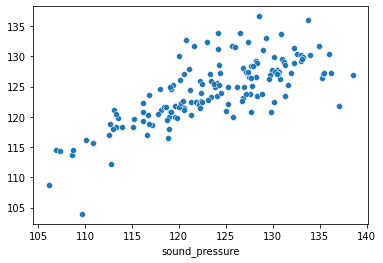

In [425]:
sns.scatterplot(Y_test, Y_pred)

C:\Users\grzes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sound_pressure'>

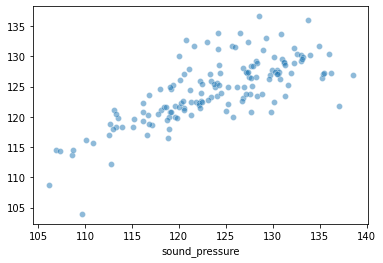

In [426]:
sns.scatterplot(Y_test, Y_pred, alpha=0.5)

### 9.Analiza dokładności modelu

W ostatnim kroku przeprowadziliśmy analizę dokładności naszego modelu

In [427]:
print('Variance score: %.2f' % r2_score(Y_test, model.predict(X_test)))

Variance score: 0.55


In [428]:
print("Mean squared error of a learned model: %.2f" % 
      mean_squared_error(Y_test, model.predict(X_test)))

Mean squared error of a learned model: 22.23
